In [15]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

# LAB 5 Support Vector Machines

In [2]:
def bias(X, y, alpha, weight, k):
    b = 0
    e = 0
    for i, j in enumerate(alpha):
        alpha[i] = np.round(alpha[i], 9)
        if 1e-10 < alpha[i] < k:
            b += y[i] - np.dot(weight.T, X[:, i])
            e += 1
    if e == 0:
        return 0
    else:
        return b / e

In [3]:
def plot_svm(weight, b):

    xx, yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
    viz = np.c_[xx.ravel(), yy.ravel()]
    z = np.dot(viz, weight) + b

    plt.imshow(z.reshape((200, 200)), interpolation='bilinear', origin='lower', extent=(-10, 10, -10, 10), alpha=0.3,
               vmin=-1, vmax=1)
    plt.contour(xx, yy, z.reshape((200, 200)), [-1., 0., 1.])
    plt.gcf().set_size_inches((9, 9))
    plt.show()

In [4]:
def generate_SVM(c1, c2, k, m):
    plt.scatter(c1[:, 0], c1[:, 1])
    plt.scatter(c2[:, 0], c2[:, 1])

    QPGC = importlib.import_module("QPGC", "./QPGC.pyc")

    X = np.concatenate((c1, c2), axis=0).T
    y = np.concatenate((np.ones(m), -np.ones(m)))
    Y = np.diag(y)

    G = np.dot(np.dot(Y, X.T), np.dot(X, Y))
    g = -np.ones(m * 2)
    A = np.reshape(y, (m * 2, 1))
    C = np.c_[np.eye(m * 2), -np.eye(m * 2)]
    b = np.zeros(1)
    d = np.concatenate((np.zeros(m * 2), -np.ones(m * 2) * k))

    alpha = QPGC.QPGenericConstraints(G, g, A, C, b, d)
    weight = np.dot(np.dot(alpha.T, Y), X.T)
    
    b = bias(X, y, alpha, weight, k)
    
    plot_svm(weight, b)

# SEPARABLE DATA

In [5]:
m1 = [0., 0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2 = [3., 6.]
s2 = [[1, 0], [0, 1]]
m = 100
c1 = np.random.multivariate_normal(m1, s1, m)
c2 = np.random.multivariate_normal(m2, s2, m)

##### All the experiments are done by using a dataset of 100 samples of positive class and 100 samples of negative class. 

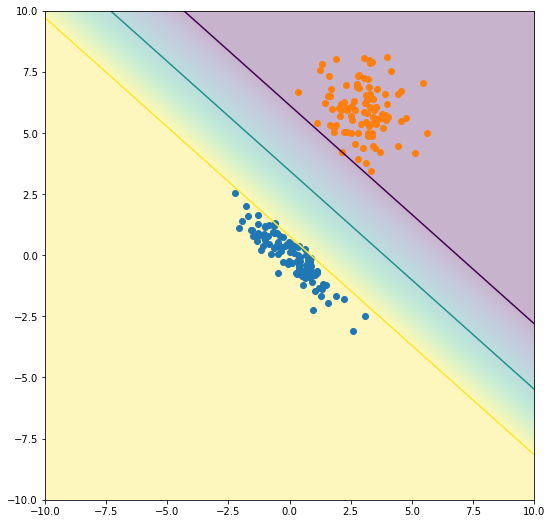

In [6]:
generate_SVM(c1, c2, 1, m)

#### With K = 1, we can see that SVM separate correctly the two classes of th sample.

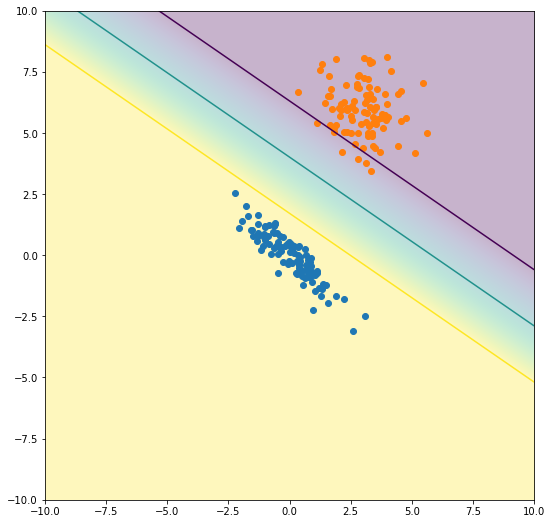

In [7]:
generate_SVM(c1, c2, 1e6, m)

###### With K = 1e6, we can see that SVM sometimes separate the classes admitting some points in the margin. Most of the cases, it is not abled to separate the classes.

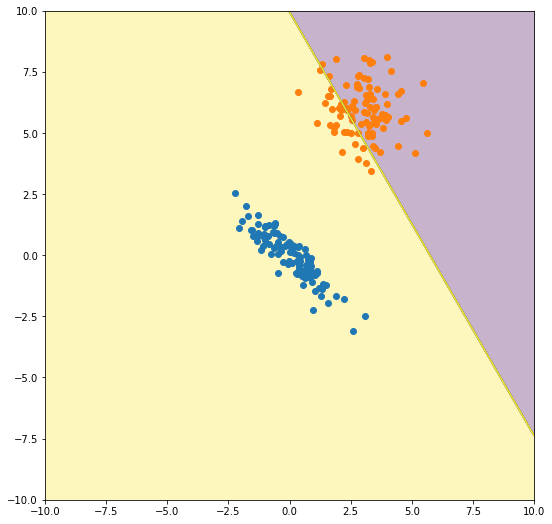

In [8]:
generate_SVM(c1, c2, 1e12, m)

###### With K = 1e12, we can see that SVM it is not abled to separate the classes.

# NON-SEPARABLE DATA



In [16]:
m1 = [0., 0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2 = [1., 2.]
s2 = [[1, 0], [0, 1]]  # Non-separable dataset
m = 100
c12 = np.random.multivariate_normal(m1, s1, m)
c22 = np.random.multivariate_normal(m2, s2, m)

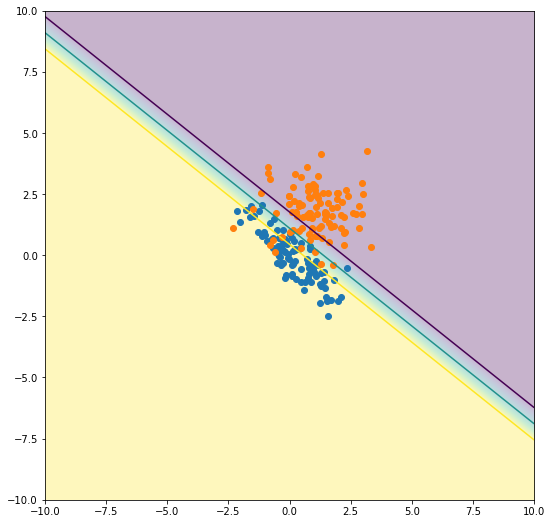

In [17]:
generate_SVM(c12, c22, 1, m)

###### With K = 1, we can see that SVM can give a descent separation in case of non-separable dataset.

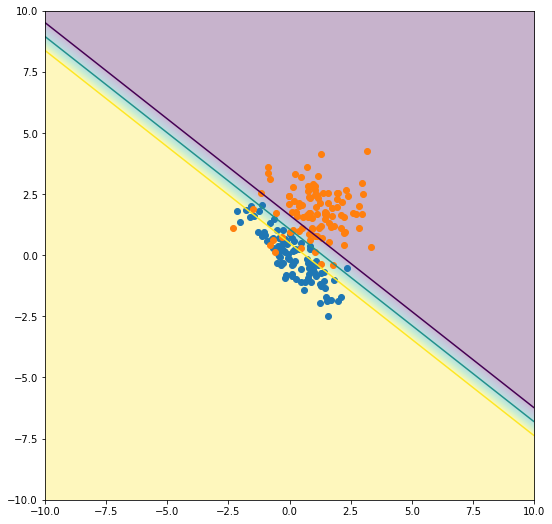

In [20]:
generate_SVM(c12, c22, 1e6, m)

###### With K = 1e6, we can see that SVM sometimes separate the classes admitting some points in the margin. Most of the cases, it is not abled to separate the classes.

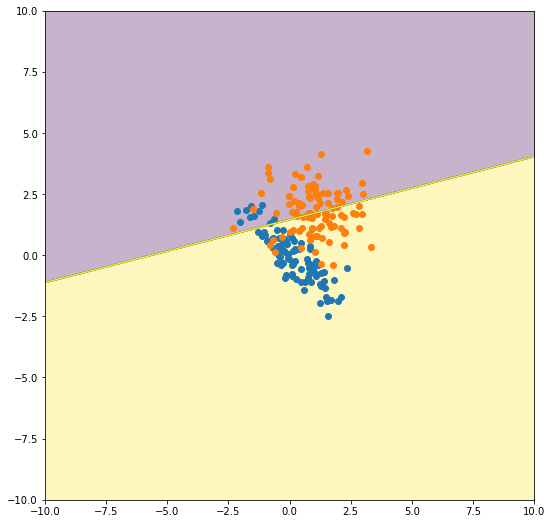

In [19]:
generate_SVM(c12, c22, 1e12, m)

###### With K = 1e12, we can see that SVM it is not abled to separate the classes.

###### To conclude, we can state that the value of K incluences our separation for the dataset. Moreover, if K is a large number,  then the SVM algorithm is unstable for separating dataset, even if the dataset is separable. This is because in SVM optimization, the value of K specifies how much we want to avoid misclassification of each training example. In the case of a large value of K, the optimization will choose a smaller-margin hyperplane if it is more likely to correctly classify all the training points. Alternatively, a very small value of K will cause the optimizer to consider a hyperplane with a larger margin of separation, even if the hyperplane misclassifies more points.

# LAB 6 Stochastic gradient descent for SVM

In [16]:
def f(w, b, lamb, X, y):
    i = lamb / 2 * np.dot(w.T, w)
    res = np.ones(y.shape) - np.dot(np.diag(y), np.dot(w.T, X.T).T + b)
    j = np.sum(np.maximum(np.zeros(y.shape), res))
    return i + j

In [17]:
def plot_svm(c1, c2, weight, b):
    plt.scatter(c1[:, 0], c1[:, 1])  # x, y
    plt.scatter(c2[:, 0], c2[:, 1])
    xx, yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
    viz = np.c_[xx.ravel(), yy.ravel()]
    z = np.dot(viz, weight) + b

    plt.imshow(z.reshape((200, 200)), interpolation='bilinear', origin='lower', extent=(-10, 10, -10, 10), alpha=0.3,
               vmin=-1, vmax=1)
    plt.contour(xx, yy, z.reshape((200, 200)), [-1., 0., 1.])
    plt.gcf().set_size_inches((9, 9))
    plt.show()

In [18]:
def stochastic_gradient(X, y, lamb=1e-4, n_batch=10, n_epochs=100, mu=100, inc=0.1, plot=False):
    initial_mu = mu
    gamma = 1 / mu

    n = 2 * m
    batch_size = int(n / n_batch)

    w_t = w = np.zeros(2)
    b_t = b = 0
    history = list()

    for t in range(n_epochs):
        X_s, y_s = shuffle(X, y)

        for batch_idx in range(n_batch):
            X_b = X_s[batch_idx * batch_size:(batch_idx + 1) * batch_size, :]
            y_b = y_s[batch_idx * batch_size:(batch_idx + 1) * batch_size]

            for X_t, y_t in zip(X_b, y_b):
                if y_t * (np.dot(w.T, X_t) + b) > 1:
                    w_t = w_t - gamma * lamb * w
                else:
                    w_t = w_t - gamma * (lamb * w - (y_t * X_t))
                    b_t = b_t - gamma * (-y_t)

            mu += inc
            gamma = 1 / mu

            w = w_t
            b = b_t

        history.append(np.log(f(w, b, lamb, X, y)))

    print("Achieved result: {} with mu {}".format(history[-1], initial_mu))
    if plot:
        plt.figure(figsize = (9,9))
        plt.plot(history)
        if n_batch == 1:
            plt.title("Classical Stochastic Gradient for SVM")
        else:
            plt.title("Minibatch Stochastic Gradient for SVM")
        plt.ylabel("ln(f(x))")
        plt.xlabel("Iterations")
        plt.show()
        
    return history, w, b

# SEPARABLE DATA

In [19]:
m1 = [0., 0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2 = [3., 6.]
s2 = [[1, 0], [0, 1]]
m = 100
c1 = np.random.multivariate_normal(m1, s1, m)
c2 = np.random.multivariate_normal(m2, s2, m)

y = np.concatenate((np.ones(m), -np.ones(m)))
X = np.concatenate((c1, c2), axis=0)

Achieved result: -10.741239107054422 with mu 100


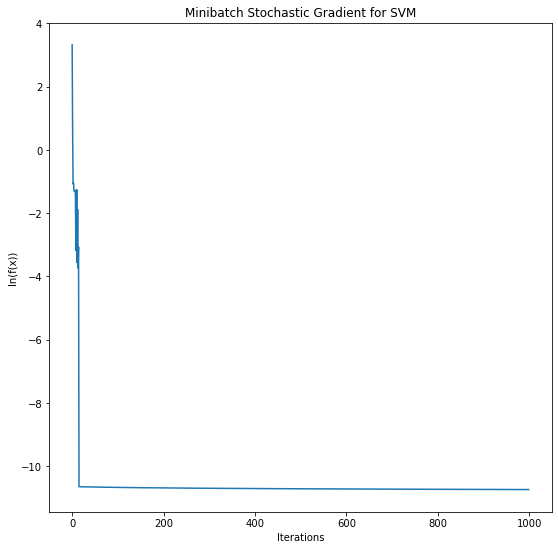

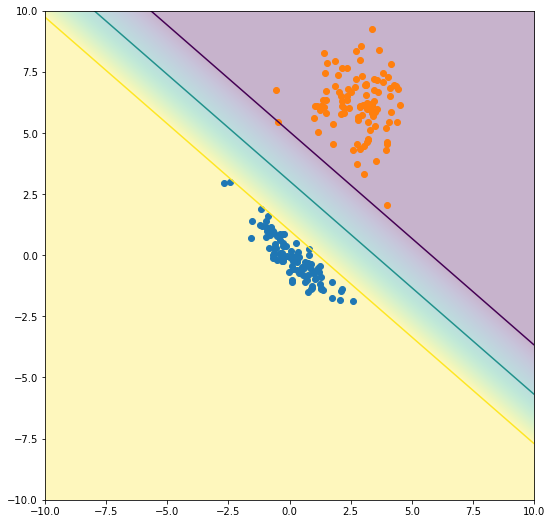

In [20]:
h, w, b = stochastic_gradient(X, y, lamb=1e-4, n_batch=10, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c1, c2, w, b)

Achieved result: -10.741553898173917 with mu 100


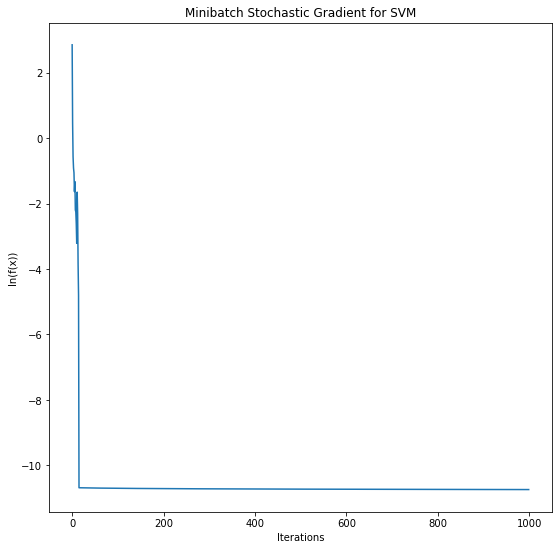

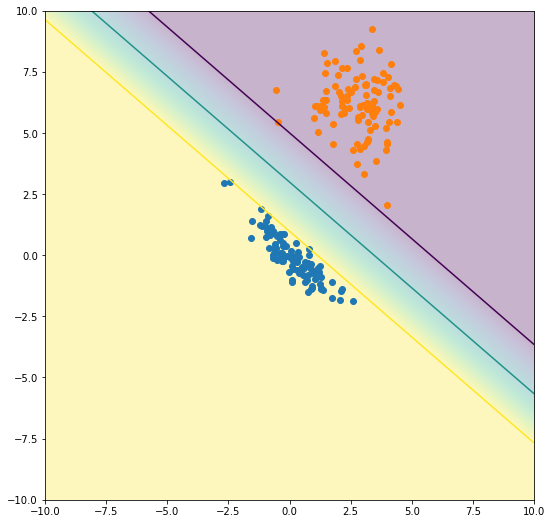

In [21]:
h, w, b = stochastic_gradient(X, y, lamb=1e-4, n_batch=20, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c1, c2, w, b)

Achieved result: -10.7589487283329 with mu 100


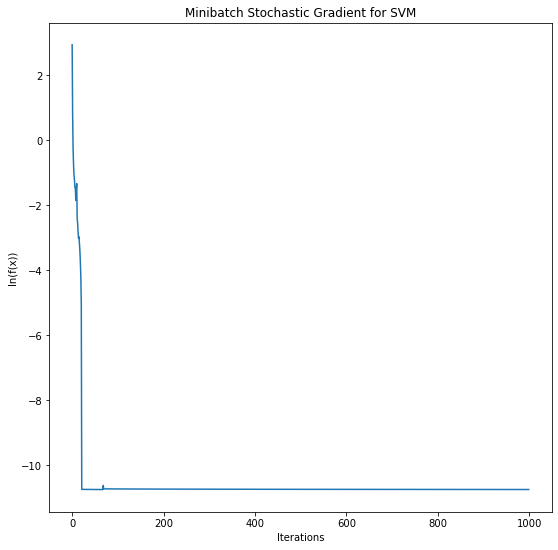

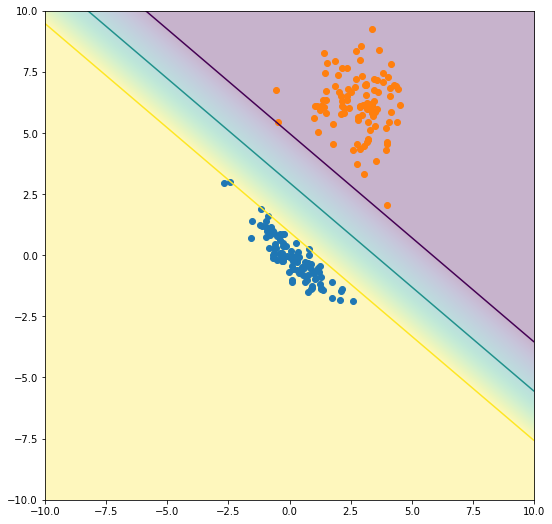

In [22]:
h, w, b = stochastic_gradient(X, y, lamb=1e-4, n_batch=50, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c1, c2, w, b)

Achieved result: -10.805766856208358 with mu 100


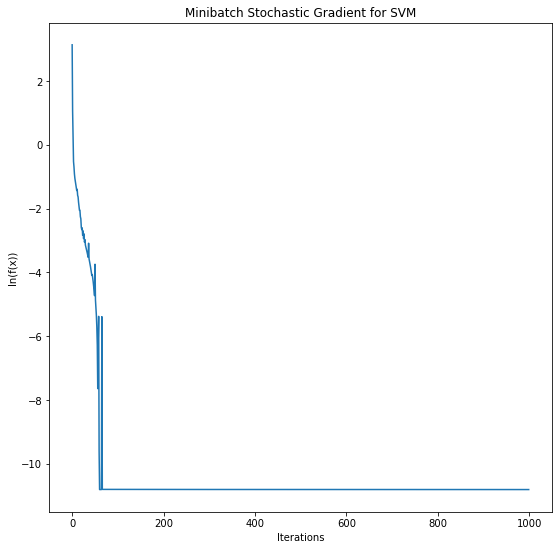

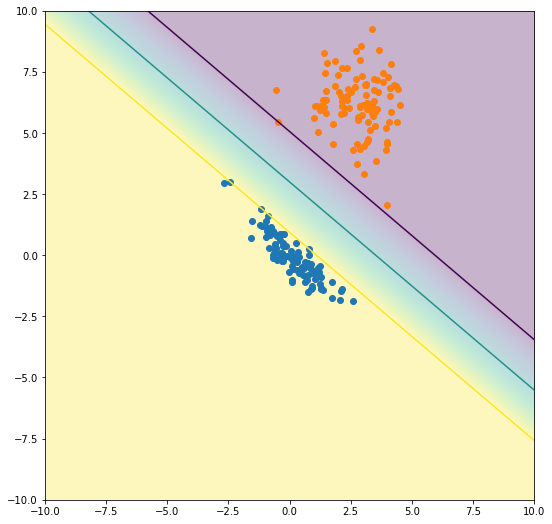

In [23]:
h, w, b = stochastic_gradient(X, y, lamb=1e-4, n_batch=200, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c1, c2, w, b)

# NON SEPARABLE DATA

In [24]:
m1 = [0., 0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2 = [1., 2.]
s2 = [[1, 0], [0, 1]]  # Non-separable dataset
m = 100
c12 = np.random.multivariate_normal(m1, s1, m)
c22 = np.random.multivariate_normal(m2, s2, m)

y2 = np.concatenate((np.ones(m), -np.ones(m)))
X2 = np.concatenate((c12, c22), axis=0)

Achieved result: 3.149237063167393 with mu 100


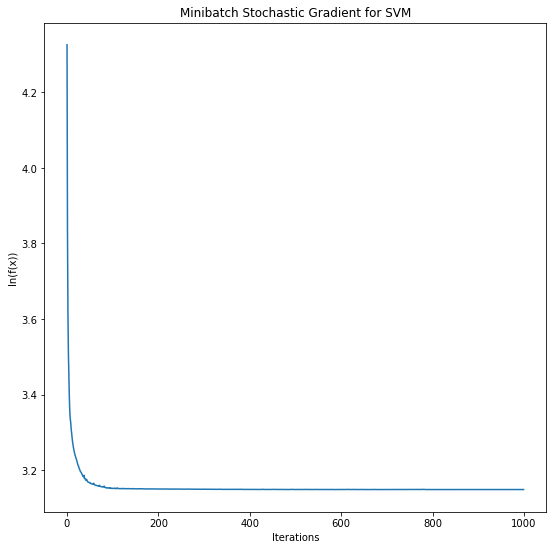

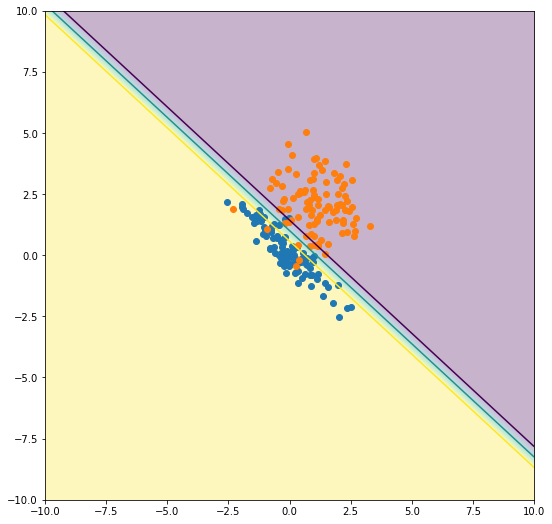

In [25]:
h, w, b = stochastic_gradient(X2, y2, lamb=1e-4, n_batch=10, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c12, c22, w, b)

Achieved result: 3.149716213006555 with mu 100


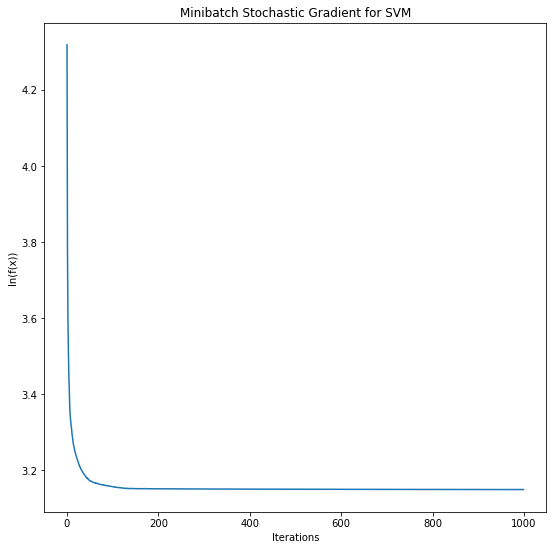

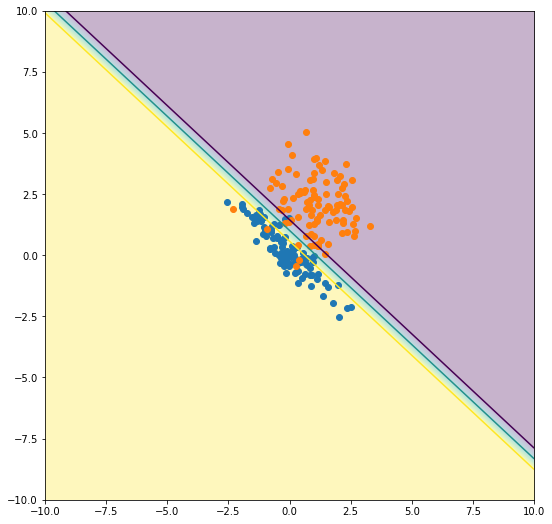

In [26]:
h, w, b = stochastic_gradient(X2, y2, lamb=1e-4, n_batch=20, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c12, c22, w, b)

Achieved result: 3.15183420540266 with mu 100


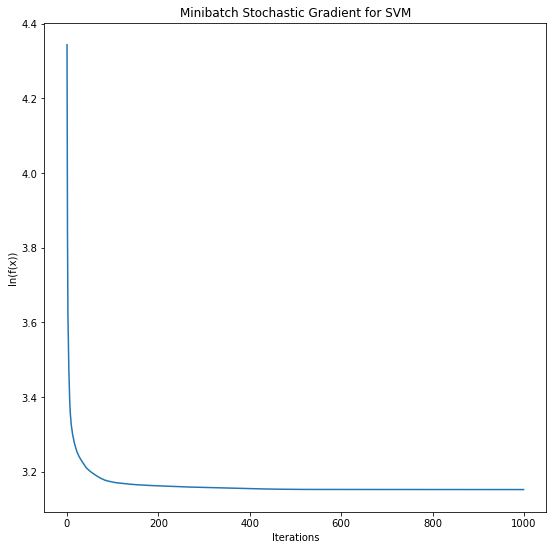

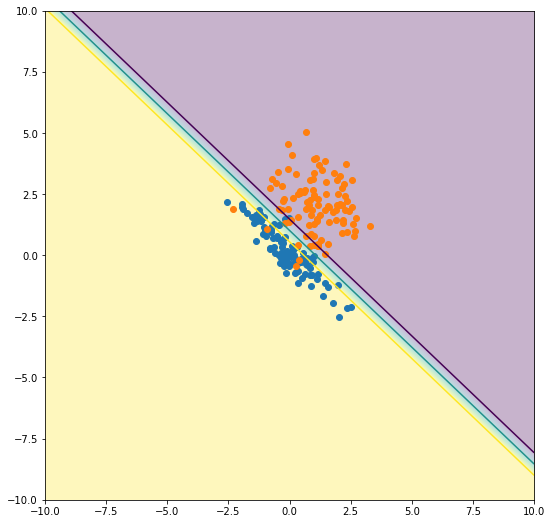

In [27]:
h, w, b = stochastic_gradient(X2, y2, lamb=1e-4, n_batch=50, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c12, c22, w, b)

Achieved result: 3.199875605342873 with mu 100


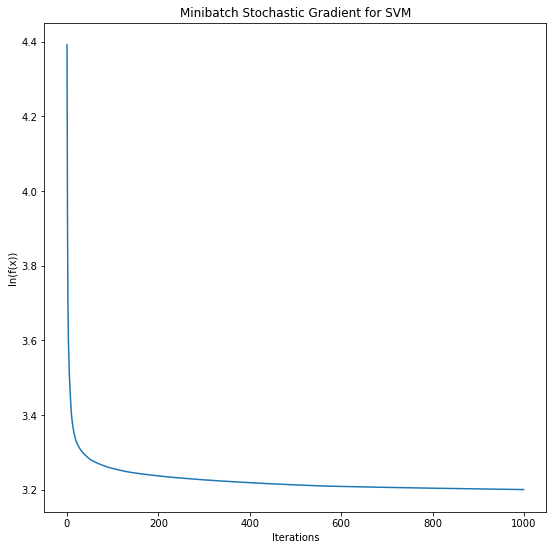

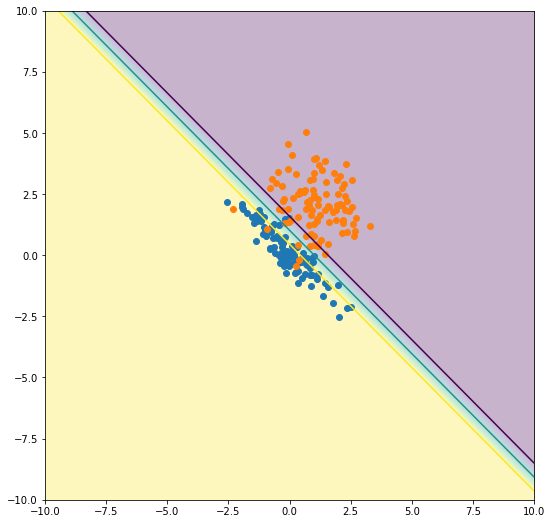

In [28]:
h, w, b = stochastic_gradient(X2, y2, lamb=1e-4, n_batch=200, n_epochs=1000, mu=100, inc=0.1, plot=True)
plot_svm(c12, c22, w, b)

###### We can assume that stochastic gradient descent method is able to converge the SVM in the primal space by configuring it into a minimization problem. We can notice that with small batch_size, the algorithm is able to find the minimum of the objective function faster.Conversely, with large batch_size, the algorithm requires more iterations to be converged. This implies that the weights are more updated, so it is possible to solve faster the classification.